<a href="https://colab.research.google.com/github/truong2710-cyber/Lab-WSN/blob/main/Algo2_Q_Connectivity_sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ortools

     |████████████████████████████████| 14.4MB 197kB/s 
     |████████████████████████████████| 1.0MB 30.7MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [ ]:
import matplotlib.pyplot as plt
import xlrd
import numpy as np
from ortools.linear_solver import pywraplp
from math import sqrt
import time
import pandas as pd
import copy
import secrets

class point:
    def __init__(self,x,y):
        self.x=x
        self.y=y

class vector:
    def __init__(self,x,y):
        self.x=x
        self.y=y


def distance(t1,t2):
    a=point(t1[0],t1[1])
    b=point(t2[0],t2[1])
    return sqrt((a.x-b.x)**2+(a.y-b.y)**2)

def intersection_point_2circle(t1,t2,r):
    a=point(t1[0],t1[1])
    b=point(t2[0],t2[1])
    if sqrt((a.x-b.x)**2+(a.y-b.y)**2)>2*r:
        return []
    m=point((a.x+b.x)/2,(a.y+b.y)/2)
    d=sqrt(r**2-((a.x-b.x)**2+(a.y-b.y)**2)/4)
    n1=d/sqrt((a.x-b.x)**2+(a.y-b.y)**2)
    n2=-n1
    i1=point((m.x+(a.y-b.y)*n1),(m.y+(b.x-a.x)*n1))
    i2=point((m.x+(a.y-b.y)*n2),(m.y+(b.x-a.x)*n2))
    return [[i1.x,i1.y],[i2.x,i2.y]]

def intersectionPoint(x,y,z,t,r):
    d=distance(x,y)
    a=vector(x[0]-y[0],x[1]-y[1])
    b=vector(z[0]-t[0],z[1]-t[1])
    x=point(x[0],x[1])
    z=point(z[0],z[1])
    if a.x*b.y-a.y*b.x!=0:
        t1=((z.x-x.x)*a.y-(z.y-x.y)*a.x)/(b.y*a.x-b.x*a.y)
        i=[(z.x+b.x*t1),(z.y+b.y*t1)]
        if a.x!=0:
            t=(z.x-x.x+b.x*t1)/a.x
        else:
            t=(z.y-x.y+b.y*t1)/a.y
        if distance(i,y)<=r and t>=-1 and d>r:
            return i
        else:
            return []
    else:
        return []
        
def intersectionPointCircle(o,p,r):
    t=r/distance(o,p)
    x=o[0]+(p[0]-o[0])*t
    y=o[1]+(p[1]-o[1])*t
    return [x,y]

def condition(x):
    return x[0]

def arrange(t,points):
    under=[x for x in points if x[1]<=t[1]]
    above=[x for x in points if x[1]>t[1]]
    under.sort(key=condition)
    above.sort(key=condition, reverse=True)
    points=above+under
    return points

def findIntersectionPoints(tList,t):
    points=[]
    for x in tList:
        if x!=t and distance(t,x)<2*r:
            points.extend(intersection_point_2circle(t,x,r))
    return points

def findIntersectionTargets(tList,point):
    intersection_targets=[]
    for t in tList:
        if distance(point,t)<=r+0.0005:
            intersection_targets.append(tList.index(t))
    return intersection_targets

def findArc(tList,t,p1,p2):
    target_set_1 = findIntersectionTargets(tList,p1) 
    target_set_2 = findIntersectionTargets(tList,p2)
    target_set_1=set(target_set_1)
    target_set_2=set(target_set_2)
    return list(target_set_1 & target_set_2)

def findCriticalRegion(tList,t):
    arc=[]
    points=findIntersectionPoints(tList,t)
    points=arrange(t,points)
    points.append(points[0])
    for x in range(len(points)-1):
        arc.append(findArc(tList,t,points[x],points[x+1]))
    return list(set(max(arc,key=len)))

def isSubset(x,region):
    for i in x:
        if i not in region:
            return False
    return True

def delete(regions):
    erase=[]
    for x in regions:
        for region in regions: 
            if x!=region and isSubset(x,region):
                erase.append(x)
    for x in erase:
        if x in regions:
            regions.remove(x)
    return regions
            
def findAllCriticalRegions(tList):
    regions=[]
    for t in tList:
        if len(findIntersectionPoints(tList,t))>0:
            if findCriticalRegion(tList,t) not in regions:
                regions.append(findCriticalRegion(tList,t))
        else:
            regions.append([tList.index(t)])
    regions=delete(regions)
    return regions
    
def solve(tList,regions,q):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    x=[[]]*len(regions)
    for i in range(len(regions)):
        x[i]=solver.IntVar(0,solver.infinity(),' ')
    for j in range(len(tList)):
        solver.Add(solver.Sum([x[i] for i in range(len(regions)) if j in regions[i]])>=q[j])
    M=solver.Sum(x)
    opjective=solver.Minimize(M)
    solver.Solve()
    #for i in range(len(regions)):
    #    print(int(x[i].solution_value()),end=' ')
    return [int(x[i].solution_value()) for i in range(len(regions))]

def minimalPoint(part,tList,r,p):
    check=True
    for x in part:
        if distance(p,tList[x])>r:
            check=False
    if check==True:
        return p
    if len(part)==1:
        if distance(p,tList[part[0]])>r:
            return intersectionPointCircle(tList[part[0]],p,r)
        else:
            return p
    c=findCommonPart(tList,part,r)
    for i in range(len(part)):
        if len(c[i])!=0:
            z=c[i][0]
            t=c[i][1]
            if z[0]!=t[0] or z[1]!=t[1]:
                if len(intersectionPoint(p,tList[part[i]],z,t,r))>0:
                    return intersectionPointCircle(tList[part[i]],p,r)
            elif intersectionPointCircle(tList[part[i]],p,r)==z and distance(tList[part[i]],p)>=r:
                return z
        
    for x in c:
        if len(x)!=0:
            m=x[0]
            break
    for l in c:
        for x in l:
            if distance(p,x)<=distance(p,m):
                m=x
    return m

def findCommonPart(tList,part,r):
    c=[]
    for i in part:
        l=[]
        erase=[]
        for j in part:
            if j!=i:
                l.extend(intersection_point_2circle(tList[i],tList[j],r))
        for x in l:
            check=True
            for j in part:
                if distance(x,tList[j])>r+0.0001:
                    check=False
                    break
            if check==False:
                erase.append(x)
        for x in erase:
            l.remove(x)
        c.append(l)
    return c
        

In [ ]:
def place_relay_nodes_between_2_sensors(s1,s2,n_bridge):
    k=int(distance(s1,s2)/Rc)
    unit_vector=vector((s2[0]-s1[0])/distance(s1,s2),(s2[1]-s1[1])/distance(s1,s2))
    for i in range(1,k+1):
        relay_nodes.extend([[s1[0]+unit_vector.x*k*Rc,s1[1]+unit_vector.y*k*Rc]]*n_bridge)

q: [2, 4, 7, 6, 4, 7, 2, 5, 3, 7]
q_sensor: [2, 4, 7, 6, 4, 7, 5, 7, 0]
regions:  [[0, 6], [8, 1], [2], [3, 6], [4], [5], [7], [9]]
centers:  [0, 1, 2, 3, 4, 5, 6, 7, 8]
Total sensors:  42
x:  [2, 4, 7, 6, 4, 7, 5, 7, 0]
Place sensors at:  [[7.759580758006324, 5.3347117711293475], [54.05813797066158, 26.923255188264633], [82.08600991455516, 85.77526878711944], [19.360073817939263, 5.3407100187418655], [63.0, 0.0], [32.56705853752834, 29.310352683775502], [48.7698378014741, 79.47677271351334], [65.21719897266934, 70.65196555372512], [0, 0]]


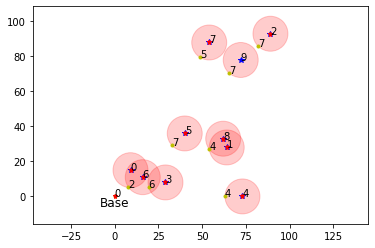

In [ ]:
np.random.seed(10)
relay_nodes=[]
Base=[0,0]
Area=100
n=10
r=10
Rc=20
tList=np.random.randint(0,Area,(n,2)).tolist()
q=np.random.randint(1,10,n).tolist()
regions=findAllCriticalRegions(tList)
x=solve(tList,regions,q)
points_to_place=[minimalPoint(regions[i],tList,r,Base) for i in range(len(x))]
q_sensor=[]
for region in regions:
    q_sensor.append(max([q[i] for i in region]))

points_to_place=[points_to_place[i] for i in range(len(x)) if x[i]!=0]
q_sensor=[q_sensor[i] for i in range(len(x)) if x[i]!=0]
x=[i for i in x if i!=0]
centers=[i for i in range(len(points_to_place))]

centers.append(len(centers))
points_to_place.append(Base)
q_sensor.append(0)
x.append(0)
print('q:',q)
print('q_sensor:',q_sensor) 
print("regions: ",regions)
print("centers: ",centers)
print("Total sensors: ",sum(x))
print("x: ",x)
print("Place sensors at: ",points_to_place)


fig, ax = plt.subplots()
for i in range(len(tList)):
     ax.add_patch(plt.Circle((tList[i][0], tList[i][1]), r, color='r', alpha=0.2))
     plt.plot(tList[i][0],tList[i][1],'b*')
     plt.text(tList[i][0],tList[i][1],str(i))
for i in range(len(points_to_place)):
    plt.plot(points_to_place[i][0],points_to_place[i][1],'y.')
    plt.text(points_to_place[i][0],points_to_place[i][1],str(x[i]))
ax.set_aspect('equal', adjustable='datalim')
plt.plot(Base[0],Base[1],"r*",markersize=5)
plt.text(Base[0],Base[1],"Base",horizontalalignment="center",verticalalignment="top",fontsize=12)
for i in centers:
    plt.plot(tList[i][0],tList[i][1],"r*",markersize=5)
plt.show()

In [ ]:
import networkx as nx
from copy import deepcopy
def distancev(a,b):
    return sqrt((a.x-b.x)**2+(a.y-b.y)**2)
def Min(p,key):
    if len(p)==0:
        return 1
    else:
        return min(p,key=key)

In [ ]:
class Vertex:
    def __init__(self,x,y,id,s):
        self.x=x
        self.y=y
        self.id=id
        self.s=s
class Net:
    def __init__(self,vertexes,n):
        self.relay_nodes_vertex=0
        self.vertexes=vertexes
        self.n_ver=n 
        self.edges={}
        for i in range(n-1):
            for j in range(i+1,n):
                self.edges[(i,j)]=[round(distancev(self.vertexes[i],self.vertexes[j]),2),0]
        self.g = nx.Graph()
        for edge in self.edges.items():
            self.g.add_edge(edge[0][0],edge[0][1],weight=edge[1][0])
        for v in vertexes:
            self.g.add_node(v.id,pos=(v.x,v.y))
    def K_shortest(self,start,end,k):
        # input id of start & end vertex
        
        #nx.draw(g,with_labels=True)
        #plt.show()
        paths=nx.shortest_simple_paths(self.g,source=start,target=end,weight='weight')
        k_shortest=[]
        count=0
        for path in paths:
            k_shortest.append(path)
            count+=1
            if count==k:
                break  
        return k_shortest
    def draw(self):
        pos=nx.get_node_attributes(self.g,'pos')
        labels = nx.get_edge_attributes(self.g,'weight')
        print(labels)
        nx.draw_networkx_edge_labels(self.g,pos,edge_labels=labels,font_size=7)
        nx.draw_networkx(self.g,pos)
        plt.show()
    def __str__(self):
        d={v.id:v.s for v in self.vertexes}
        return str(d)

In [ ]:
class Paths:
    def __init__(self,paths,net,q):
        self.paths=paths
        self.source_net=net
        self.q=q
        self.modify_net=deepcopy(self.source_net)
        self.start=paths[0][0]
        vertexes=[]
        for path in paths:
            vertexes+=path[1:-1]
        self.vertexes_in_paths=set(vertexes)
    def count_separate_paths(self,modify=True):
        if modify==False:
            backup=deepcopy(self.modify_net)
        count=0
        for path in self.paths:
            if len(path)==2:
                count+=1
                continue
            min_s=min(path[1:-1],key=lambda v:self.modify_net.vertexes[v].s)
            count+=self.modify_net.vertexes[min_s].s
            for v in path[1:-1]:
                self.modify_net.vertexes[v].s-=self.modify_net.vertexes[min_s].s
        if modify==False:
            self.modify_net=backup
        return count
    def check_and_duplicate(self):
        count=self.count_separate_paths()
        if count<self.q:
            while True:
              min_s_vertex=Min(self.vertexes_in_paths,key=lambda v:self.modify_net.vertexes[v].s)
              #print("min_s=",min_s_vertex)
              self.modify_net.vertexes[min_s_vertex].s+=1
              self.source_net.vertexes[min_s_vertex].s+=1
              self.source_net.relay_nodes_vertex+=1
              relay_nodes.append([self.source_net.vertexes[min_s_vertex].x,self.source_net.vertexes[min_s_vertex].y])
              #print("After+1:",self.modify_net)
              new_count=self.count_separate_paths()-1
              #print("new_count=",new_count)
              #print(self.modify_net)
              count+=new_count
              if count>=self.q:
                  break
    def add_bridges(self):
        net_copy=deepcopy(self.source_net)
        for path in self.paths:
            if len(path)==2:
                continue
            min_s=min(path[1:-1],key=lambda v:net_copy.vertexes[v].s)
            for i in range(len(path)-1):
                if path[i]<path[i+1]:
                    edge=(path[i],path[i+1])
                else:
                    edge=(path[i+1],path[i])
                n_bridge=net_copy.vertexes[min_s].s
                current_bridge=self.source_net.edges[edge][1]
                if current_bridge<n_bridge:
                    self.source_net.edges[edge][1]=n_bridge
                if i>0:
                    net_copy.vertexes[path[i]].s-=net_copy.vertexes[min_s].s   
              

{0: 2, 1: 4, 2: 7, 3: 6, 4: 4, 5: 7, 6: 5, 7: 7, 8: 0}
{(0, 1): 51.08, (0, 2): 109.52, (0, 3): 11.6, (0, 4): 55.5, (0, 5): 34.5, (0, 6): 84.73, (0, 7): 86.99, (0, 8): 9.42, (1, 2): 65.19, (1, 3): 40.86, (1, 4): 28.37, (1, 5): 21.62, (1, 6): 52.82, (1, 7): 45.13, (1, 8): 60.39, (2, 3): 102.0, (2, 4): 87.87, (2, 5): 75.1, (2, 6): 33.91, (2, 7): 22.66, (2, 8): 118.72, (3, 4): 43.97, (3, 5): 27.37, (3, 6): 79.76, (3, 7): 79.8, (3, 8): 20.08, (4, 5): 42.25, (4, 6): 80.74, (4, 7): 70.69, (4, 8): 63.0, (5, 6): 52.72, (5, 7): 52.68, (5, 8): 43.81, (6, 7): 18.67, (6, 8): 93.25, (7, 8): 96.15}


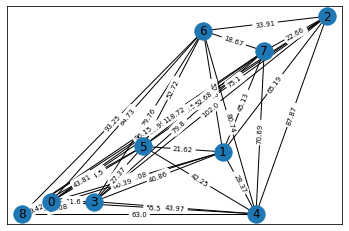

4
4


In [ ]:
relay_nodes=[]
n_center=len(centers)
vertexes=[0 for i in range(n_center)]
for i in range(n_center):
    vertexes[i]=Vertex(points_to_place[i][0],points_to_place[i][1],i,x[i])
net=Net(vertexes,n_center)
print(net)
net.draw()
for i in range(n_center-1):
    paths=net.K_shortest(i,n_center-1,2)
    p=Paths(paths,net,q_sensor[i])
    p.check_and_duplicate()
    p.add_bridges()
    #print(net)
print(len(relay_nodes))
print(net.relay_nodes_vertex)


In [ ]:
#relay_nodes=[]
for edge in net.edges.items():
    place_relay_nodes_between_2_sensors([net.vertexes[edge[0][0]].x,net.vertexes[edge[0][0]].y],[net.vertexes[edge[0][1]].x,net.vertexes[edge[0][1]].y],edge[1][1])

print("Number of relay nodes:",len(relay_nodes))



Number of relay nodes: 117


NameError: ignored

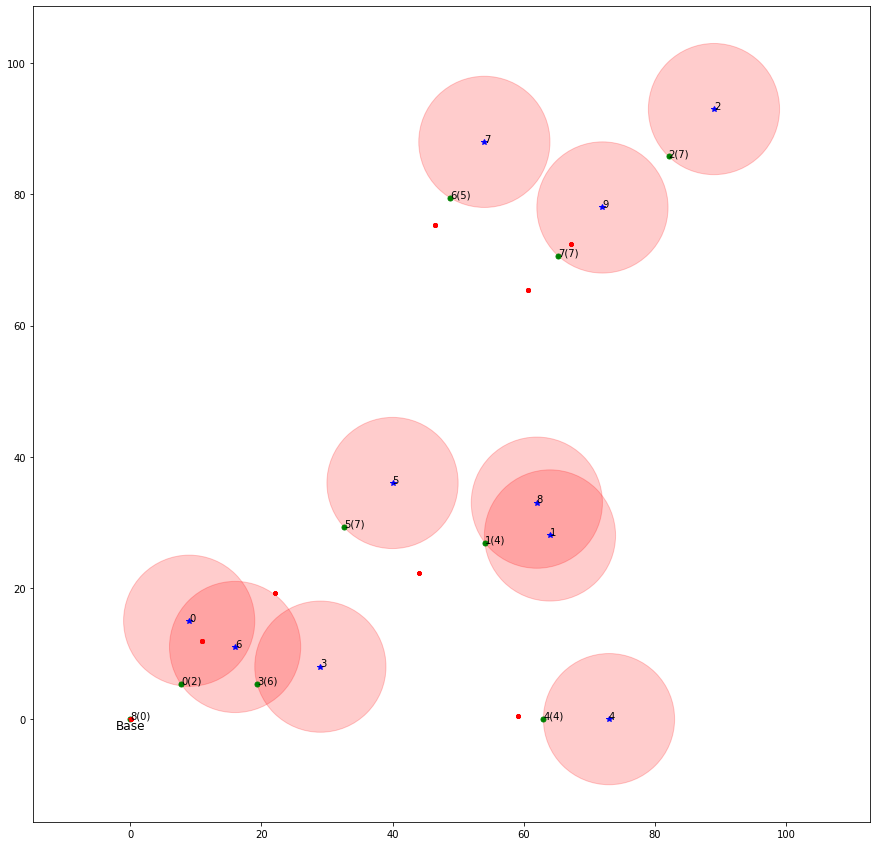

In [ ]:
points_to_place_ext=points_to_place.copy()
points_to_place_ext.append(Base)

fig, ax = plt.subplots(figsize=(15,15))

for i in range(len(tList)):
     ax.add_patch(plt.Circle((tList[i][0], tList[i][1]), r, color='r', alpha=0.2))
     plt.plot(tList[i][0],tList[i][1],'b*')
     plt.text(tList[i][0],tList[i][1],str(i))
for i in range(len(points_to_place)):
    plt.plot(points_to_place[i][0],points_to_place[i][1],'g.',markersize=10)
    plt.text(points_to_place[i][0],points_to_place[i][1],str(i)+"("+str(x[i])+")")
ax.set_aspect('equal', adjustable='datalim')
plt.plot(Base[0],Base[1],"r*",markersize=5)
plt.text(Base[0],Base[1],"Base",horizontalalignment="center",verticalalignment="top",fontsize=12)
for node in relay_nodes:
    plt.plot(node[0],node[1],"r.",markersize=7)
for u in range(len(adjacency_list)):
    for v in adjacency_list[u]:
        if u<v:
            plt.plot([points_to_place_ext[u][0],points_to_place_ext[v][0]],[points_to_place_ext[u][1],points_to_place_ext[v][1]],'b-')

plt.show()